In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Wczytuję dane

In [3]:
dane=pd.read_csv('titanic.csv')

Sprawdzam co jest nie tak z danymi

In [12]:
dane.info()
dane.head(20)
dane.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    int64  
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked_C  891 non-null    int64  
 8   Embarked_Q  891 non-null    int64  
 9   Embarked_S  891 non-null    int64  
 10  FamilySize  891 non-null    int64  
 11  IsAlone     891 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 83.7 KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.127946,0.523008,0.381594,33.226215,0.188552,0.086420,0.725028,1.904602,0.602694
std,0.486592,0.836071,0.477990,13.220830,1.102743,0.806057,49.845882,0.391372,0.281141,0.446751,1.613459,0.489615
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,8.050000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,3.000000,1.000000,26.000000,0.000000,0.000000,14.500000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,31.275000,0.000000,0.000000,1.000000,2.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,11.000000,1.000000


Zakładam że jeśli Wiek jest mniejszy niż 1 to jest to błąd przy wpisywaniu i poprawiam zapis
Usuwam część po przecinku wieku
Braki uzupełniam średnią wieku dla danej płci oraz klasy podróży 

In [6]:

dane.loc[dane['Age'] < 1, 'Age'] = dane.loc[dane['Age'] < 1, 'Age'] * 10
dane.loc[dane['Age']%1!=0, 'Age']=dane.loc[dane['Age']%1!=0, 'Age'].floordiv(1)
age_medians=dane.groupby(['Pclass', 'Sex'])['Age'].median()
def fill_age(row):
    if pd.isna(row['Age']):
        return age_medians.loc[row['Pclass'], row['Sex']]
    return row['Age']
dane['Age'] = dane.apply(fill_age, axis=1)

Cenę biletu uzupełniam szukając osób z tym samym biletem i podaną ceną
Resztę uzupełniam średnią ceny dla danej klasy

In [7]:
ticket_to_fare=dane.dropna(subset=['Fare']).groupby('Ticket')['Fare'].first()
class_to_fare=dane.groupby('Pclass')['Fare'].mean()
dane["Fare"]=dane['Fare'].fillna(dane['Ticket'].map(ticket_to_fare))
dane.loc[dane['Fare'].isna(), 'Fare']=dane.loc[dane['Fare'].isna(), 'Pclass'].map(class_to_fare)

Uzupełniam brakujące dane najczęściej powtarzającą się wartością(Brakuje 2 Wartości i tak nic to nie zmieni)

In [8]:
dane.loc[dane['Embarked'].isna(), 'Embarked']='S'

Usuwam niepotrzebne kolumny i zamieniam kolumnę Embarked oraz Sex tak aby mieć dane w pełni numeryczne(1 dla male i 0 dla female)

In [9]:
dane.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'], inplace=True)
dane=pd.get_dummies(dane, columns=['Embarked'], prefix='Embarked')
dane['Sex']=dane['Sex']=='male'
for col in dane.columns:
    if col != 'Fare':
        dane[col]=dane[col].astype(int)

Dodaję kolumny FamilySize co jest wielkością rodziny na pokładzie i IsAlone czyli wartość (1/0) czy ktoś jest sam czy też nie

In [10]:
dane['FamilySize']=dane['SibSp'] + dane['Parch'] + 1
dane['IsAlone'] = (dane['FamilySize'] == 1).astype(int)

Zależność przeżywalności od płci(Znacznie więcej kobiet przeżyło niż mężczyzn)

<Axes: xlabel='Sex', ylabel='Survived'>

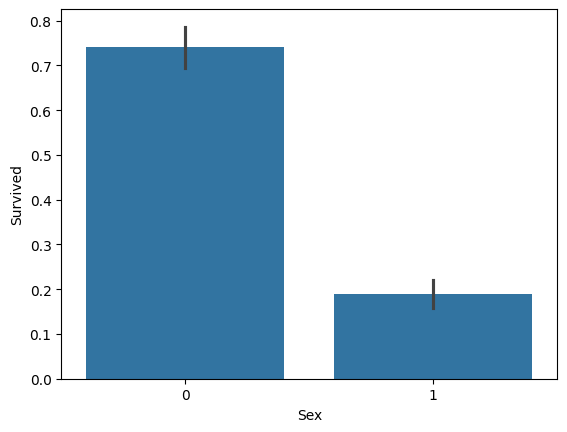

In [11]:
sns.barplot(data=dane, x='Sex', y='Survived' )

Zależność klasy podróży na przeżywalność(wyższa klasa-większe szanse na przeżycie)

<Axes: xlabel='Pclass', ylabel='Survived'>

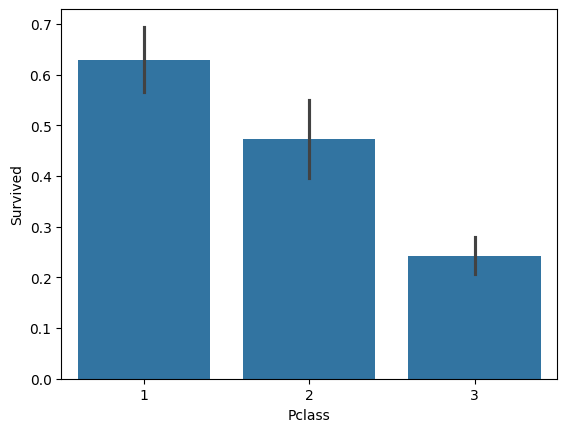

In [13]:
sns.barplot(data=dane, x='Pclass', y='Survived')

Przedział wiekowy do przeżywalności(20-30 największa przeżywalność)

<Axes: xlabel='Age', ylabel='Count'>

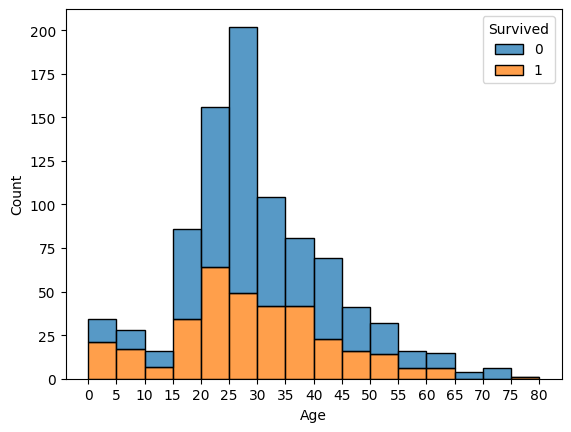

In [14]:
bins1=np.arange(0, dane['Age'].max()+5, 5)
plt.xticks(bins1)
sns.histplot(data=dane, x='Age', hue='Survived', multiple='stack', bins=bins1)

Zależność Ceny od przeżywalności-im więcej zapłacisz tym większa szansa na przeżycie

<Axes: xlabel='Survived', ylabel='Fare'>

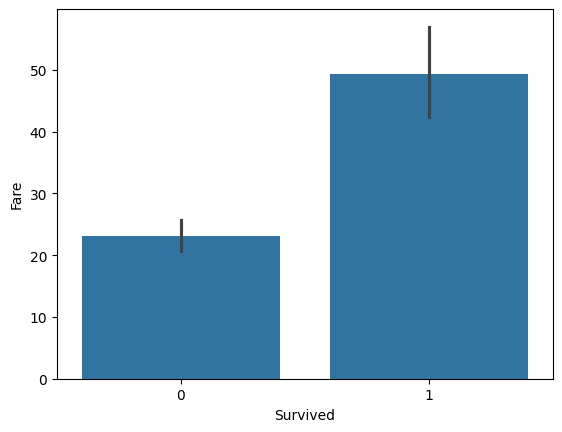

In [16]:
sns.barplot(data=dane, x='Survived', y='Fare')

Zależność Wielkości rodziny na pokładzie do przeżywalności(Jak jest was 4 to macie największą szansę przeżycia)

<Axes: xlabel='FamilySize', ylabel='Survived'>

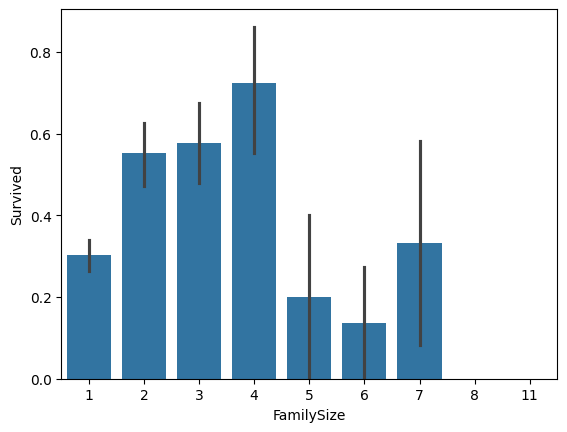

In [15]:
sns.barplot(data=dane, x='FamilySize', y='Survived')

Więcej samotnych niż z rodziną kobiet przeżyło podczas gdy dla mężczyzn było odwrotnie

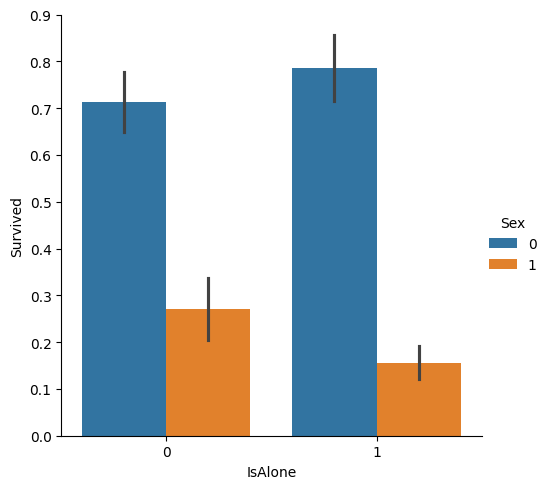

In [22]:
sns.catplot(data=dane, x='IsAlone', y='Survived', hue='Sex', kind='bar')

Rozkład wieku w grupach klasy podróży i wieku

<Axes: xlabel='Pclass', ylabel='Age'>

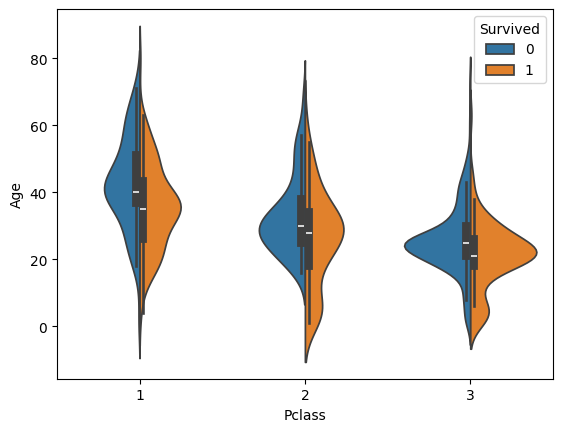

In [24]:
sns.violinplot(data=dane, x='Pclass', y='Age', hue='Survived', split=True)

Prosta Heatmapa

<Axes: >

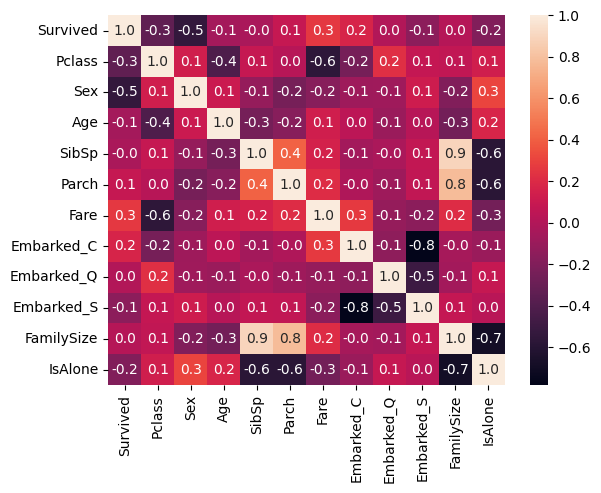

In [29]:
sns.heatmap(dane.corr(), annot=True, fmt='.1f')

Najwięcej ludzi z Southampton przeżyło

<Axes: xlabel='None'>

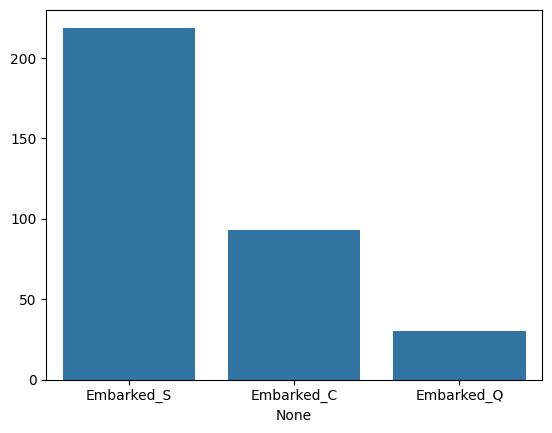

In [19]:
sursived=dane[['Embarked_S','Embarked_C','Embarked_Q']].where(dane['Survived'] == 1).sum()
sns.barplot(x=sursived.index, y=sursived.values)